In [1]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

In [7]:
import json

ww1_false = set(json.loads(open("/mnt/anal/false_cjtxs_ww1.json").read()))
c = 0

ww1_false = list(sorted(map(lambda tx: chain.tx_with_hash(tx), ww1_false), key=lambda t: t.block_time))
for tx in ww1_false:
    print(tx.hash)
    print(tx.block_time)
    if tx.is_wasabi1_coinjoin:
        print(blocksci.CoinJoinType(tx.coinjoin_tag))
        for i in tx.inputs:
            print(f"is ww1 cj? {i.index} {i.spent_tx.is_wasabi1_coinjoin}")
        print(tx.mempool_space_link)
        c += 1

b9d011e1a183deae7be7ef722f553a83af43dbd9280dbe6f7f5f29b94988d3cb
2018-08-03 15:52:10
CoinJoinType.WW1
is ww1 cj? 0 False
is ww1 cj? 1 False
is ww1 cj? 2 False
is ww1 cj? 3 False
is ww1 cj? 4 False
is ww1 cj? 5 False
is ww1 cj? 6 False
is ww1 cj? 7 False
is ww1 cj? 8 False
is ww1 cj? 9 False
is ww1 cj? 10 False
is ww1 cj? 11 False
https://mempool.space/tx/b9d011e1a183deae7be7ef722f553a83af43dbd9280dbe6f7f5f29b94988d3cb
200697a0906e239b059a873b6b8f51b15b613f377a9fb26f6a180bfd556eeac7
2018-08-05 16:22:46
CoinJoinType.WW1
is ww1 cj? 0 True
is ww1 cj? 1 False
is ww1 cj? 2 False
is ww1 cj? 3 False
is ww1 cj? 4 False
is ww1 cj? 5 False
https://mempool.space/tx/200697a0906e239b059a873b6b8f51b15b613f377a9fb26f6a180bfd556eeac7
375ddec472e84ae07d89c9b97f720c3b062db330ff9ea9ba8a74b8b8bd5e3942
2018-08-28 18:47:27
CoinJoinType.WW1
is ww1 cj? 0 False
is ww1 cj? 1 False
is ww1 cj? 2 False
is ww1 cj? 3 False
is ww1 cj? 4 False
is ww1 cj? 5 False
is ww1 cj? 6 False
is ww1 cj? 7 False
is ww1 cj? 8 False


In [2]:
"""
Table structure
cj pool | operating period | total cjtxs | fresh inputs | remix rate | unmoved UTXOs | num of inputs (min, avg, max)
ww1
ww2 (zkSNACKs)
ww2 
wp all
wp 5m
wp 1m
wp 50m
wp 100k
"""
april_24_block_height = get_block_height_for_date('2024-04-24')
june_1_block_height = get_block_height_for_date('2024-06-02')
last_august_block_height = get_block_height_for_date('2024-08-31')

In [3]:
%time ww2_cjs = chain.filter_coinjoin_txes(0, june_1_block_height, "ww2")
%time ww2_cjs_hashes = set(str(tx.hash) for tx in ww2_cjs)
len(ww2_cjs)

CPU times: user 1min 3s, sys: 43.5 s, total: 1min 47s
Wall time: 1.02 s
CPU times: user 56.8 ms, sys: 101 ms, total: 158 ms
Wall time: 152 ms


34790

In [4]:
%time ww2_cjs_other = chain.filter_coinjoin_txes(june_1_block_height, last_august_block_height, "ww2")
%time ww2_cjs_other_hashes = set(str(tx.hash) for tx in ww2_cjs_other)
len(ww2_cjs_other)

CPU times: user 4.41 s, sys: 2.47 s, total: 6.88 s
Wall time: 138 ms
CPU times: user 1.23 ms, sys: 15 ms, total: 16.2 ms
Wall time: 13.4 ms


2469

In [14]:
%time wp_cjs = chain.filter_coinjoin_txes(0, april_24_block_height, "wp")
%time wp_cjs_hashes = set(str(tx.hash) for tx in wp_cjs)
len(wp_cjs)

CPU times: user 1min 21s, sys: 719 ms, total: 1min 21s
Wall time: 1.47 s
CPU times: user 664 ms, sys: 52.8 ms, total: 717 ms
Wall time: 719 ms


540999

In [8]:
%time ww1_cjs = chain.filter_coinjoin_txes(0, june_1_block_height, "ww1")
%time ww1_cjs_hashes = set(str(tx.hash) for tx in ww1_cjs) - set(ww1_false)
len(ww1_cjs)

CPU times: user 2min 25s, sys: 279 ms, total: 2min 25s
Wall time: 2.37 s
CPU times: user 45.6 ms, sys: 2.15 ms, total: 47.7 ms
Wall time: 46.7 ms


34682

In [9]:
god_set_of_all_coinjoins = ww1_cjs_hashes | wp_cjs_hashes | ww2_cjs_hashes | ww2_cjs_other_hashes
print(len(ww1_cjs), len(ww1_cjs_hashes))


34682 34682


In [10]:
import copy
import json

wp_stats = {
    "all_txes": 0,
    "all_inputs": 0,
    "all_inputs_value": 0,
    "fresh_inputs": 0,
    "fresh_inputs_value": 0,
    "all_outputs": 0,
    "remixed_outputs": 0,
    "unmoved_outputs": 0,
    "unmoved_outputs_value": 0,
    "traverse_inputs": 0,
    "traverse_inputs_value": 0
}

ww2_stats = copy.deepcopy(wp_stats)
ww2_other_stats = copy.deepcopy(wp_stats)
ww1_stats = copy.deepcopy(wp_stats)

whirlpool_stats = {
    "all": copy.deepcopy(wp_stats),
    "5m": copy.deepcopy(wp_stats),
    "1m": copy.deepcopy(wp_stats),
    "50m": copy.deepcopy(wp_stats),
    "100k": copy.deepcopy(wp_stats),
}

def get_pool(ws, tx):
    max_pool_value = max(x.value for x in tx.outputs)
    if max_pool_value == 5000000:
        return ws["5m"]
    if max_pool_value == 1000000:
        return ws["1m"]
    if max_pool_value == 50000000:
        return ws["50m"]
    if max_pool_value == 100000:
        return ws["100k"]

    raise ValueError(f"wtf {max_pool_value}")

def check_fdnp(tx: blocksci.Tx) -> int:
    s = 0
    
    for i in tx.inputs:
        if str(i.spent_tx.hash) in ww2_cjs_hashes or str(i.spent_tx.hash) in ww2_cjs_other_hashes:
            s += i.value

    return s


def should_ignore_input(tx):
    s = 0
    rv = False
    for i in tx.inputs:
        sp_tx = i.spent_tx
        if str(sp_tx.hash) in ww1_cjs_hashes:
            s += i.value
            rv = True
        elif str(i.spent_tx.hash) in ww2_cjs_hashes or str(i.spent_tx.hash) in ww2_cjs_other_hashes:
            s += i.value
            rv = True
    return s, rv

from collections import defaultdict
from typing import Dict, Set, List


def get_stats_for_cj(
    the_stats: Dict[str, int], 
    tx_objects: List[blocksci.Tx], 
    given_cjs: Set[str], 
    is_whirlpool: bool = False, 
    is_ww2: bool = False, 
    is_ww1: bool = False
):
    tx: blocksci.Tx
    tx_input: blocksci.Input
    tx_output: blocksci.Output
    dd_int = defaultdict(int)

    for tx in tx_objects:
        # filter out false positives
        if str(tx.hash) not in given_cjs:
            continue

        if is_whirlpool:
            tx_pool = get_pool(the_stats, tx)
            current_stats = the_stats["all"]
        else:
            tx_pool = dd_int
            current_stats = the_stats

        current_stats["all_txes"] += 1
        tx_pool["all_txes"] += 1
        
        current_stats["all_inputs"] += tx.input_count
        for tx_input in tx.inputs:
            current_stats["all_inputs_value"] += tx_input.value
            
            if str(tx_input.spent_tx.hash) not in given_cjs:
                how_much = 0
                ignore = False
                if is_ww1 or is_ww2:
                    how_much, ignore = should_ignore_input(tx_input.spent_tx)
  
                current_stats["fresh_inputs"] += (0 if ignore else 1) 
                tx_pool["fresh_inputs"] += 1 
                current_stats["fresh_inputs_value"] += (tx_input.value if not ignore else 0)
                tx_pool["fresh_inputs_value"] += tx_input.value

            if str(tx_input.spent_tx.hash) not in given_cjs and str(tx_input.spent_tx.hash) in god_set_of_all_coinjoins:
                current_stats["traverse_inputs"] += 1
                tx_pool["traverse_inputs"] += 1
                current_stats["traverse_inputs_value"] += tx_input.value
                tx_pool["traverse_inputs_value"] += tx_input.value

            if str(tx_input.spent_tx.hash) in given_cjs:
                current_stats["remixed_outputs"] += 1  
                tx_pool["remixed_outputs"] += 1  

        current_stats["all_outputs"] += tx.output_count
        tx_pool["all_outputs"] += tx.output_count
        for tx_output in tx.outputs:
            if not tx_output.is_spent:
                current_stats["unmoved_outputs"] += 1
                tx_pool["unmoved_outputs"] += 1
                current_stats["unmoved_outputs_value"] += tx_output.value
                tx_pool["unmoved_outputs_value"] += tx_output.value
                continue
                


In [11]:
%time get_stats_for_cj(whirlpool_stats, wp_cjs, wp_cjs_hashes, is_whirlpool=True)
%time get_stats_for_cj(ww2_stats, ww2_cjs, ww2_cjs_hashes, is_ww2=True)
%time get_stats_for_cj(ww2_other_stats, ww2_cjs_other, ww2_cjs_other_hashes, is_ww2=True)
%time get_stats_for_cj(ww1_stats, ww1_cjs, ww1_cjs_hashes, is_ww1=True)

CPU times: user 1min 41s, sys: 1.54 s, total: 1min 43s
Wall time: 1min 43s
CPU times: user 2min 4s, sys: 1.41 s, total: 2min 5s
Wall time: 2min 6s
CPU times: user 16.1 s, sys: 184 ms, total: 16.2 s
Wall time: 16.3 s
CPU times: user 58.3 s, sys: 799 ms, total: 59.1 s
Wall time: 59.5 s


In [12]:
from tabulate import tabulate

In [13]:
print(tabulate(
    [
        [
            "Wasabi 1.0 (zkSNACKs)", 
            "2018-07-19 – 2024-06-01", 
            len(ww1_cjs_hashes), 
            f"{ww1_stats['fresh_inputs'] // 1000}k/{round(ww1_stats['fresh_inputs_value'] / 100000000, 1)} BTC", 
            f"{round((ww1_stats['remixed_outputs'] / ww1_stats['all_outputs']) * 100, 1)}%", 
            f"{round((ww1_stats['unmoved_outputs'] / (ww1_stats['all_outputs'] - ww1_stats['remixed_outputs'])) * 100, 1)}%, {round(ww1_stats['unmoved_outputs_value'] / 100000000, 0)}"
        ],
        [
            "Wasabi 2.0 (zkSNACKs)", 
            "2022-06-18 – 2024-06-01", 
            len(ww2_cjs_hashes), 
            f"{ww2_stats['fresh_inputs'] // 1000}k/{round(ww2_stats['fresh_inputs_value'] / 100000000, 0)} BTC", 
            f"{round((ww2_stats['remixed_outputs'] / ww2_stats['all_outputs']) * 100, 1)}%", 
            f"{round((ww2_stats['unmoved_outputs'] / (ww2_stats['all_outputs'] - ww2_stats['remixed_outputs'])) * 100, 1)}%, {round(ww2_stats['unmoved_outputs_value'] / 100000000, 0)}"        
        ],
        [
            "Wasabi 2.0 (other)", 
            "2024-06-01 – current", 
            len(ww2_cjs_other_hashes), 
            f"{ww2_other_stats['fresh_inputs'] // 1000}k/{round(ww2_other_stats['fresh_inputs_value'] / 100000000, 0)} BTC", 
            f"{round((ww2_other_stats['remixed_outputs'] / ww2_other_stats['all_outputs']) * 100, 1)}%", 
            f"{round((ww2_other_stats['unmoved_outputs'] / (ww2_other_stats['all_outputs'] - ww2_other_stats['remixed_outputs'])) * 100, 1)}%, {round(ww2_other_stats['unmoved_outputs_value'] / 100000000, 0)}"        
        ],
        *(
            [
                f"Whirlpool {key}", 
                "2019-04-17 – 2024-04-24", 
                whirlpool_stats[key]["all_txes"], 
                f"{whirlpool_stats[key]['fresh_inputs'] // 1000}k/{round(whirlpool_stats[key]['fresh_inputs_value'] / 100000000, 1)} BTC", 
                f"{round((whirlpool_stats[key]['remixed_outputs'] / max(whirlpool_stats[key]['all_outputs'], 1)) * 100, 1)}%", 
                f"{round(whirlpool_stats[key]['unmoved_outputs'] / (max((whirlpool_stats[key]['all_outputs'] - whirlpool_stats[key]['remixed_outputs']), 1)) * 100, 1)}%, {round(whirlpool_stats[key]['unmoved_outputs_value'] / 100000000, 0)}"        
            ] for key in whirlpool_stats
        )
        
    ],
    headers=['Pool', 'Operating period', "Total cjtxs", "Fresh inputs", "Remix rate", "Unmoved UTXOs"], 
    tablefmt='orgtbl'
    )
)


| Pool                  | Operating period        |   Total cjtxs | Fresh inputs      | Remix rate   | Unmoved UTXOs   |
|-----------------------+-------------------------+---------------+-------------------+--------------+-----------------|
| Wasabi 1.0 (zkSNACKs) | 2018-07-19 – 2024-06-01 |         34682 | 354k/254715.0 BTC | 53.2%        | 2.8%, 4014.0    |
| Wasabi 2.0 (zkSNACKs) | 2022-06-18 – 2024-06-01 |         34790 | 271k/71431.0 BTC  | 86.0%        | 6.1%, 6909.0    |
| Wasabi 2.0 (other)    | 2024-06-01 – current    |          2469 | 16k/3167.0 BTC    | 74.6%        | 19.0%, 771.0    |
| Whirlpool all         | 2019-04-17 – 2024-04-24 |        540999 | 1134k/47289.5 BTC | 61.0%        | 10.6%, 8411.0   |
| Whirlpool 5m          | 2019-04-17 – 2024-04-24 |        112094 | 233k/11701.7 BTC  | 61.4%        | 10.9%, 1271.0   |
| Whirlpool 1m          | 2019-04-17 – 2024-04-24 |        205624 | 434k/4359.3 BTC   | 60.1%        | 8.8%, 384.0     |
| Whirlpool 50m         | 2019-0

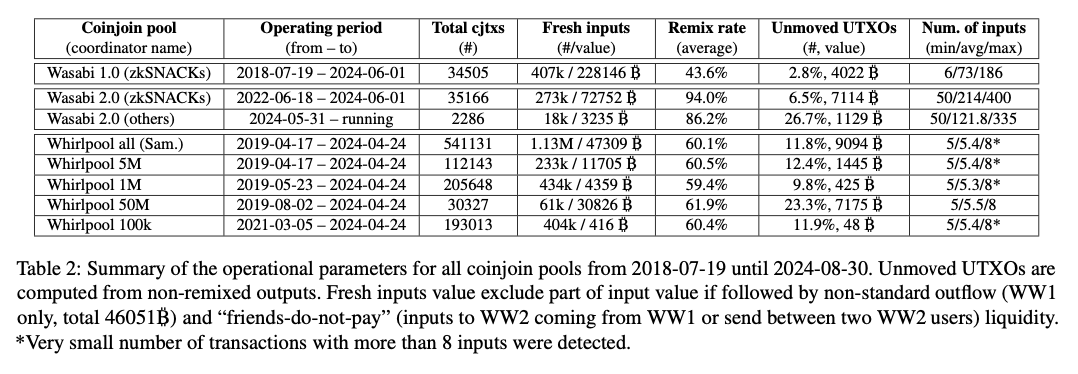

In [58]:
from typing import Dict
data: Dict[str, blocksci.address_type] = {}



df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by timeframe and script type
grouped = df.groupby([df['timestamp'], 'script_type']).size().reset_index(name='count')

# Pivot to get counts of each script type per timestamp
pivot_df = grouped.pivot(index='timestamp', columns='script_type', values='count').fillna(0)

# Calculate total transactions per timestamp and percentages
pivot_df['total'] = pivot_df.sum(axis=1)
percentages = pivot_df.div(pivot_df['total'], axis=0) * 100
percentages = percentages.drop(columns=['total'])

# Plotting
plt.figure(figsize=(12, 6))
percentages.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Bitcoin Script Type Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.legend(title='Script Type')
plt.grid()
plt.show()



0 0


In [20]:
import json

with open('/mnt/anal/coinjoin_tx_info.json') as f:
    ww1_all_dumplings = json.load(f)


ww1_blocksci = chain.filter_coinjoin_txes(0, len(chain), 'ww1')